# Machine Learning Nhóm 3

## Project: Stock Price Predictor

* Mục đích của dự án này là dự đoán chính xác giá trị đóng cửa trong tương lai của một cổ phiếu nhất định trong một khoảng thời gian nhất định trong tương lai.
* (http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)

## Lấy dữ liệu

Crawl dữ liệu trên trang CafeF

   **Bước 1 :** Sử dụng tập dữ liệu chứng khoán của VNA

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive


In [1]:
import pandas as pd
import datetime
import numpy as np

 **Bước 2:** Xem bộ dữ liệu VNA

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/HUCE_CS/CS_Nam_3/Machine Learning/StockPrediction/Gốc final/VNA.csv', header=0)

In [ ]:
data

,Unnamed: 0,Ngày,Giá điều chỉnh,Giá đóng cửa,Giá bình quân,thay đổi,KL1,GT1,KL2,GT2,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất
0,0,09/12/2021,33.4,33.4,33.40,0.70 (2.14 %),"127,191","4,248,383,000",0,0,32.70,32.5,34.0,32.5
1,1,08/12/2021,32.7,32.7,32.70,0.20 (0.62 %),"97,900","3,196,500,000",0,0,32.50,33.0,33.1,32.3
2,2,07/12/2021,32.8,32.8,32.80,0.10 (0.31 %),"127,404","4,135,342,600",0,0,32.70,32.0,33.0,32.0
3,3,06/12/2021,32.2,32.2,32.20,-0.90 (-2.72 %),"174,710","5,710,207,000",0,0,33.10,32.6,33.4,31.5
4,4,03/12/2021,32.6,32.6,32.60,-1.20 (-3.55 %),"110,027","3,643,343,000",0,0,33.80,33.6,34.0,32.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,3278,15/09/2008,38.2,38.2,27.15,11.26 (41.82 %),"484,330","18,711,456,000",0,0,26.94,37.9,39.7,37.9
3279,3279,12/09/2008,37.9,37.9,26.94,9.61 (33.99 %),"2,480","93,992,000",0,0,28.29,37.9,37.9,37.9
3280,3280,11/09/2008,39.8,39.8,28.29,10.09 (33.97 %),"35,120","1,397,776,000",0,0,29.71,39.8,39.8,39.8
3281,3281,10/09/2008,41.8,41.8,29.71,10.53 (33.67 %),"223,650","9,348,730,000","31,000","1,295,800,000",31.27,41.8,41.9,41.8


# Check Point #1

Đã crawl data và load vào DataFrame

## Tiền xử lí dữ liệu

Chúng ta sẽ tiền xử lí dữ liêu và chuẩn hóa nó để dự đoán tốt hơn

**Bước 1 :** Kiểm tra kiểu dữ liệu của các trường 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3283 entries, 0 to 3282
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3283 non-null   int64  
 1   Ngày            3283 non-null   object 
 2   Giá điều chỉnh  3283 non-null   float64
 3   Giá đóng cửa    3283 non-null   float64
 4   Giá bình quân   3283 non-null   float64
 5   thay đổi        3283 non-null   object 
 6   KL1             3283 non-null   object 
 7   GT1             3283 non-null   object 
 8   KL2             3283 non-null   object 
 9   GT2             3283 non-null   object 
 10  Giá tham chiếu  3283 non-null   float64
 11  Giá mở cửa      3283 non-null   float64
 12  Giá cao nhất    3283 non-null   float64
 13  Giá thấp nhất   3283 non-null   float64
dtypes: float64(7), int64(1), object(6)
memory usage: 359.2+ KB


* Ta thấy, tập dữ liệu hiện tại có 7(float64) và 6(object)
* Ta cần chuyển `Ngày` sang dạng `DateTime`
* `thay đổi`, `KL1`, `GT1`, `KL2`, `GT2` sang `float64`

In [ ]:
data.head()

,Unnamed: 0,Ngày,Giá điều chỉnh,Giá đóng cửa,Giá bình quân,thay đổi,KL1,GT1,KL2,GT2,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất
0,0,09/12/2021,33.4,33.4,33.4,0.70 (2.14 %),"127,191","4,248,383,000",0,0,32.7,32.5,34.0,32.5
1,1,08/12/2021,32.7,32.7,32.7,0.20 (0.62 %),"97,900","3,196,500,000",0,0,32.5,33.0,33.1,32.3
2,2,07/12/2021,32.8,32.8,32.8,0.10 (0.31 %),"127,404","4,135,342,600",0,0,32.7,32.0,33.0,32.0
3,3,06/12/2021,32.2,32.2,32.2,-0.90 (-2.72 %),"174,710","5,710,207,000",0,0,33.1,32.6,33.4,31.5
4,4,03/12/2021,32.6,32.6,32.6,-1.20 (-3.55 %),"110,027","3,643,343,000",0,0,33.8,33.6,34.0,32.6


Tách dữ liệu ở cột `Thay đổi` thành 2 cột mới do có 2 giá trị cùng 1 lúc trong cột 'Thay đổi'

In [ ]:
# Xử lý cột Thay đổi
data[['Change_Value','Change_Percent']] = data['thay đổi'].str.split("(",expand=True)

# Cắt ký tự thừa ở cột Change_Percent
data['Change_Percent'] = data['Change_Percent'].str[:-3]

In [ ]:
# convert sang float
data['Change_Percent'] = data['Change_Percent'].astype(float)
data['Change_Value'] = data['Change_Value'].astype(float)

In [ ]:
data.head()

,Unnamed: 0,Ngày,Giá điều chỉnh,Giá đóng cửa,Giá bình quân,thay đổi,KL1,GT1,KL2,GT2,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,Change_Value,Change_Percent
0,0,09/12/2021,33.4,33.4,33.4,0.70 (2.14 %),"127,191","4,248,383,000",0,0,32.7,32.5,34.0,32.5,0.7,2.14
1,1,08/12/2021,32.7,32.7,32.7,0.20 (0.62 %),"97,900","3,196,500,000",0,0,32.5,33.0,33.1,32.3,0.2,0.62
2,2,07/12/2021,32.8,32.8,32.8,0.10 (0.31 %),"127,404","4,135,342,600",0,0,32.7,32.0,33.0,32.0,0.1,0.31
3,3,06/12/2021,32.2,32.2,32.2,-0.90 (-2.72 %),"174,710","5,710,207,000",0,0,33.1,32.6,33.4,31.5,-0.9,-2.72
4,4,03/12/2021,32.6,32.6,32.6,-1.20 (-3.55 %),"110,027","3,643,343,000",0,0,33.8,33.6,34.0,32.6,-1.2,-3.55


Chuyển các cột KL1, GT1, KL2, GT2 về kiểu float và gộp thành 2 cột là KL và GT



*   KL: KHỐI LƯỢNG GIAO DỊCH
*   GT: GIÁ TRỊ GIAO DỊCH



In [ ]:
column = ['KL1', 'GT1', 'KL2', 'GT2']
for col in column:
  # xóa dấu phẩy trên trường dữ liệu và convert -> float
  data[col] = data[col].str.replace(",", '')
  data[col] = data[col].astype(float)

In [ ]:
data['KL'] = data['KL1'] + data['KL2']
data['GT'] = data['GT1'] + data['GT2']

Xóa các cột không cần thiết

In [ ]:
data = data.drop(columns=['Unnamed: 0',	'thay đổi', 'KL1', 'GT1', 'KL2', 'GT2'])

In [ ]:
data.head()

,Ngày,Giá điều chỉnh,Giá đóng cửa,Giá bình quân,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,Change_Value,Change_Percent,KL,GT
0,09/12/2021,33.4,33.4,33.4,32.7,32.5,34.0,32.5,0.7,2.14,127191.0,4.248383e+09
1,08/12/2021,32.7,32.7,32.7,32.5,33.0,33.1,32.3,0.2,0.62,97900.0,3.196500e+09
2,07/12/2021,32.8,32.8,32.8,32.7,32.0,33.0,32.0,0.1,0.31,127404.0,4.135343e+09
3,06/12/2021,32.2,32.2,32.2,33.1,32.6,33.4,31.5,-0.9,-2.72,174710.0,5.710207e+09
4,03/12/2021,32.6,32.6,32.6,33.8,33.6,34.0,32.6,-1.2,-3.55,110027.0,3.643343e+09


Chuyển đổi cột Ngày sang dữ liệu Datetime

In [ ]:
# converting dates/time columns into a datetime object
data["Ngày"] = pd.to_datetime(data["Ngày"])

# set the new datetime column as the index
data = data.set_index("Ngày")

# create new columns from datetime index
data['day'] = data.index.day
data["year"] = data.index.year
data["month"] = data.index.month

# new dataframe
data.head()

Việc chuyển đột Datatime object thành index của dataFrame sẽ giúp dễ truy vấn về sau

In [ ]:
# filter by date
data.loc["2021-01-28"]

,Giá điều chỉnh,Giá đóng cửa,Giá bình quân,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,Change_Value,Change_Percent,KL,GT,day,year,month
Ngày,,,,,,,,,,,,,,
2021-01-28,4.0,4.0,4.0,4.6,4.5,4.5,4.0,-0.6,-13.04,211500.0,858500000.0,28,2021,1


Đảo dữ liệu theo thứ tự từ quá khứ đến tương lai

In [ ]:
data = data.iloc[::-1]
data

,Giá điều chỉnh,Giá đóng cửa,Giá bình quân,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,Change_Value,Change_Percent,KL,GT,day,year,month
Ngày,,,,,,,,,,,,,,
2008-09-09,44.0,44.0,31.27,46.00,49.0,49.9,43.5,-2.00,-4.35,309380.0,1.423669e+10,9,2008,9
2008-10-09,41.8,41.8,29.71,31.27,41.8,41.9,41.8,10.53,33.67,254650.0,1.064453e+10,9,2008,10
2008-11-09,39.8,39.8,28.29,29.71,39.8,39.8,39.8,10.09,33.97,35120.0,1.397776e+09,9,2008,11
2008-12-09,37.9,37.9,26.94,28.29,37.9,37.9,37.9,9.61,33.99,2480.0,9.399200e+07,9,2008,12
2008-09-15,38.2,38.2,27.15,26.94,37.9,39.7,37.9,11.26,41.82,484330.0,1.871146e+10,15,2008,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12,32.6,32.6,32.60,33.80,33.6,34.0,32.6,-1.20,-3.55,110027.0,3.643343e+09,12,2021,3
2021-06-12,32.2,32.2,32.20,33.10,32.6,33.4,31.5,-0.90,-2.72,174710.0,5.710207e+09,12,2021,6
2021-07-12,32.8,32.8,32.80,32.70,32.0,33.0,32.0,0.10,0.31,127404.0,4.135343e+09,12,2021,7


In [ ]:
data.describe()

,Giá điều chỉnh,Giá đóng cửa,Giá bình quân,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,Change_Value,Change_Percent,day,year,month
count,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000
mean,7.099845,7.100366,6.282175,6.274755,7.100040,7.253667,6.928620,0.825681,6.309034,15.864758,2014.778252,6.706062
std,8.418407,8.418170,7.296647,7.299473,8.436545,8.640416,8.194641,1.759081,11.904480,8.641868,3.842836,3.399257
min,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,-5.000000,-14.890000,1.000000,2008.000000,1.000000
25%,2.400000,2.400000,2.400000,2.400000,2.400000,2.500000,2.300000,0.000000,0.000000,8.500000,2011.000000,4.000000
50%,3.200000,3.200000,3.200000,3.200000,3.200000,3.300000,3.100000,0.000000,0.000000,16.000000,2015.000000,7.000000
75%,7.950000,7.950000,7.100000,7.100000,8.000000,8.000000,7.800000,0.500000,10.530000,23.000000,2018.000000,10.000000
max,47.800000,47.800000,47.800000,47.100000,49.000000,49.900000,45.000000,12.880000,47.630000,31.000000,2021.000000,12.000000


**Bước 2 :** Visualize tập dữ liệu vừa được tiền xử lí

In [ ]:
# seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (25, 10)

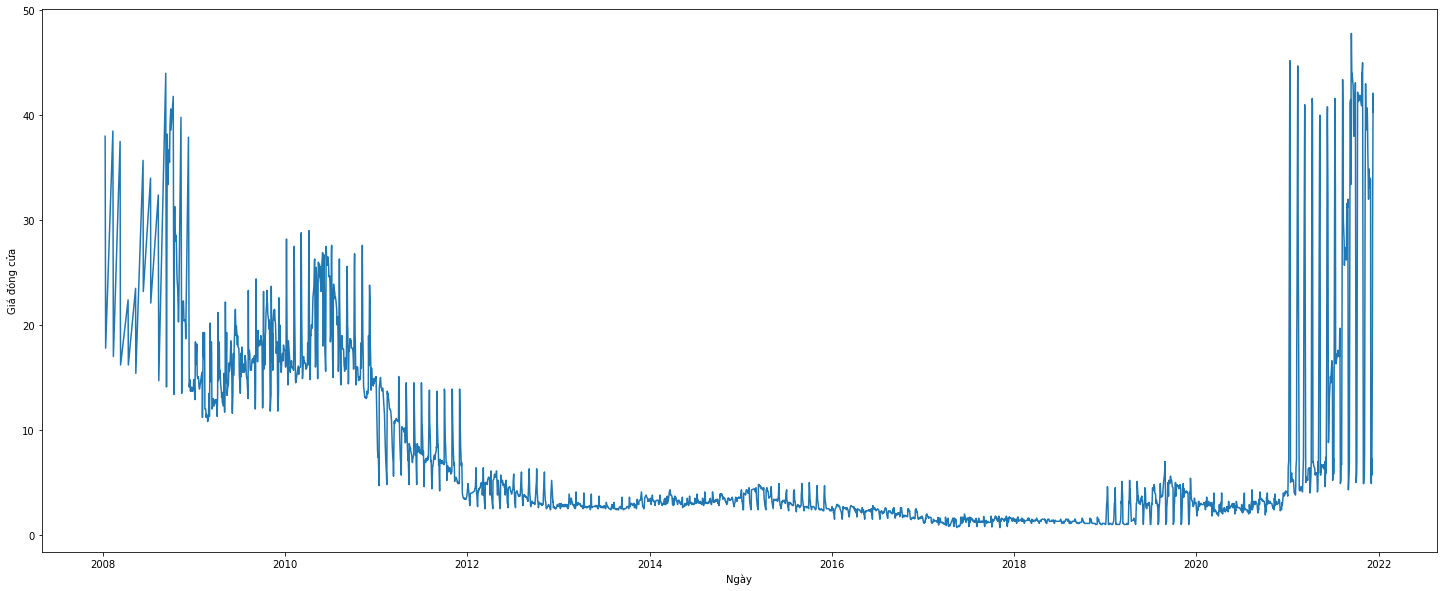

In [ ]:
# plot dữ liệu time series với trục X là index, trục Y là giá đóng cửa
sns.lineplot(data = data["Giá đóng cửa"])

In [ ]:
# Chia thanh 2 khoang thoi gian
first_period = data.loc["2008": "2015"]
second_period = data.loc["2016": "2022"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  This is separate from the ipykernel package so we can avoid doing imports until


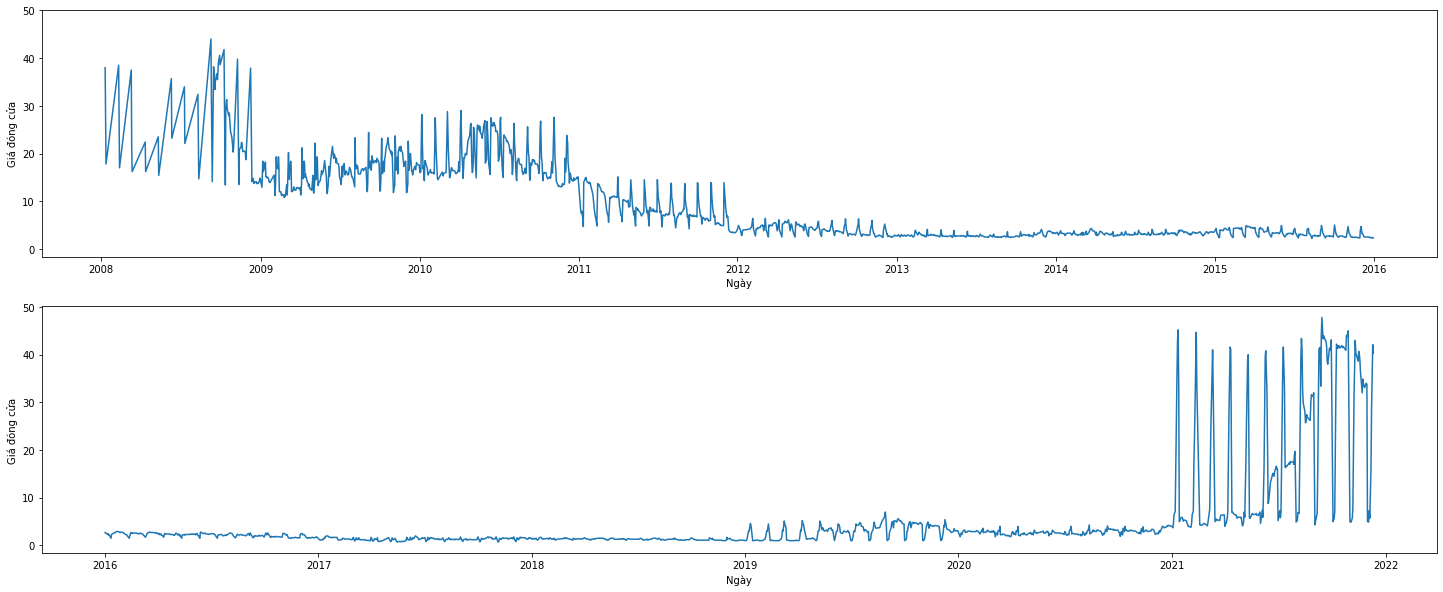

In [ ]:
# BIỂU ĐỒ GIÁ ĐÓNG CỬA VỚI 2 KHOẢNG THỜI GIAN
fig, axes = plt.subplots(2, 1, figsize=(25, 10), sharey=True)

sns.lineplot(ax=axes[0], data=first_period['Giá đóng cửa'])

sns.lineplot(ax=axes[1], data=second_period['Giá đóng cửa'])


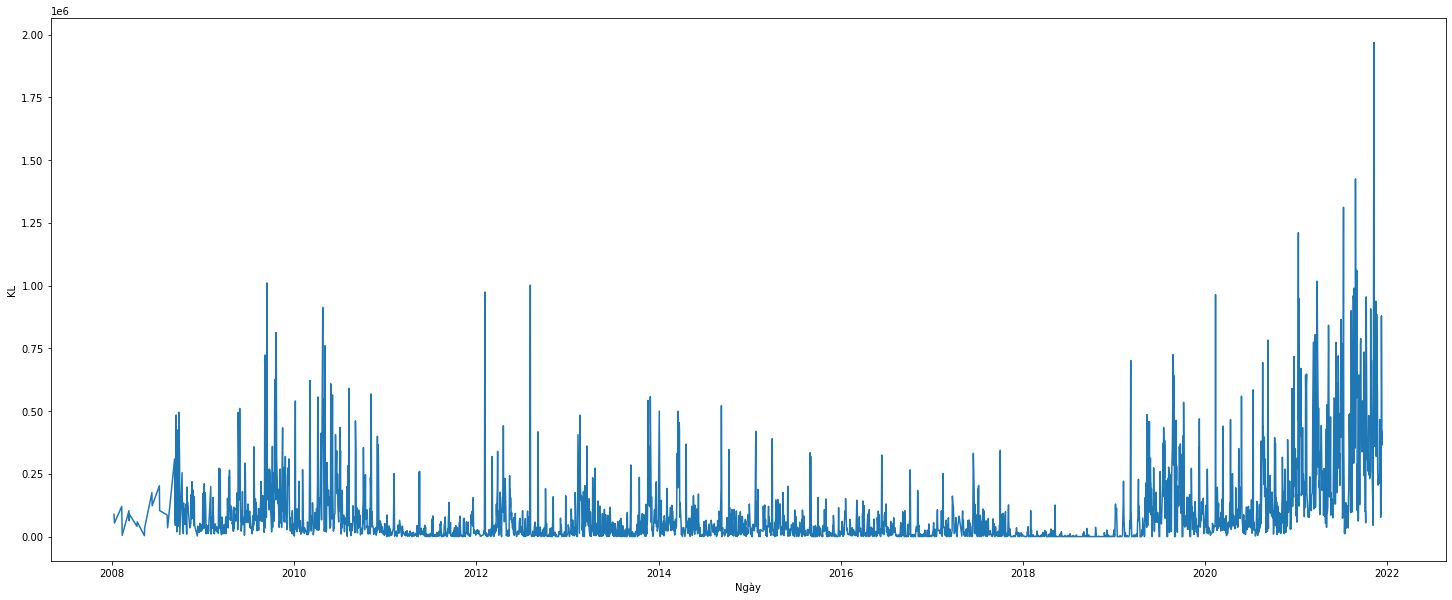

In [ ]:
# plot khoi luong giao dich tu truoc den nay
sns.lineplot(data = data["KL"])

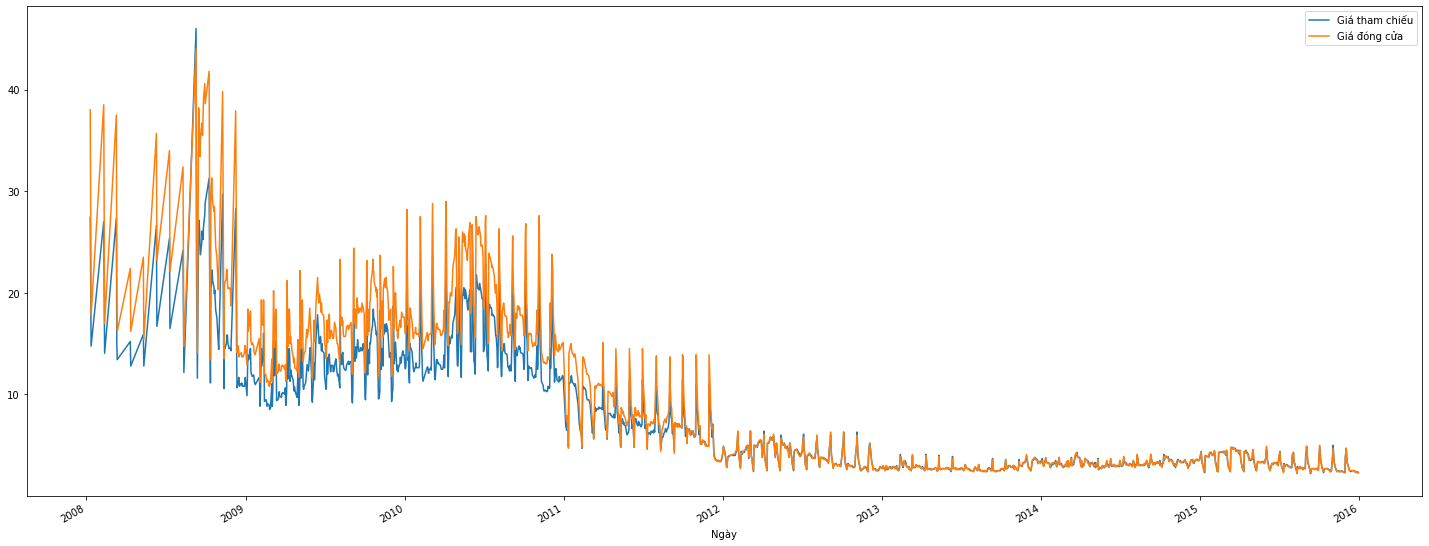

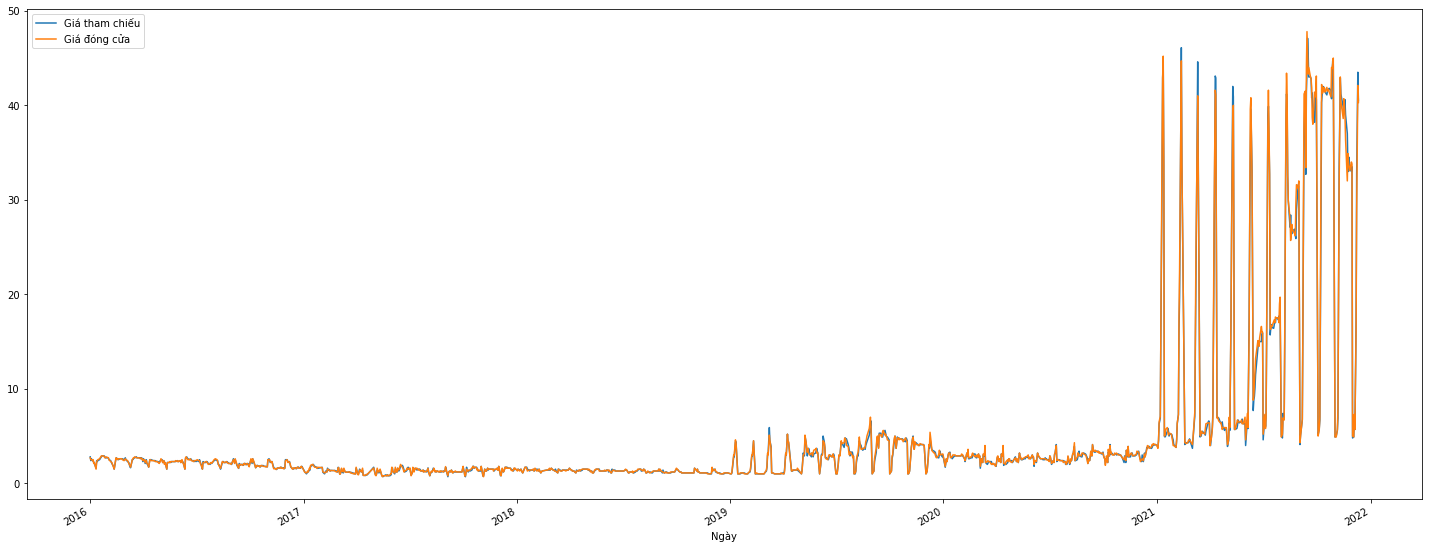

In [ ]:
# BIỂU ĐỒ GIÁ ĐÓNG CỬA VỚI 2 KHOẢNG THỜI GIAN
#fig, axes = plt.subplots(2, 1, figsize=(25, 10), sharey=True)

first_period[ ['Giá tham chiếu', 'Giá đóng cửa'] ].plot()

second_period[ ['Giá tham chiếu', 'Giá đóng cửa'] ].plot()


**Bước 3 :** Chuẩn hóa dữ liệu số bằng hàm minmaxscaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def get_normalised_data(data):
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler()
    numerical = ['Giá điều chỉnh', 'Giá đóng cửa', 'Giá bình quân', 'Giá tham chiếu', 'Giá mở cửa', 'Giá cao nhất',
                'Giá thấp nhất', 'Change_Value', 'Change_Percent', 'KL', 'GT']
    data[numerical] = scaler.fit_transform(data[numerical])
    return data

In [ ]:
data.columns

Index(['Giá điều chỉnh', 'Giá đóng cửa', 'Giá bình quân', 'Giá tham chiếu',
       'Giá mở cửa', 'Giá cao nhất', 'Giá thấp nhất', 'Change_Value',
       'Change_Percent', 'KL', 'GT', 'day', 'year', 'month'],
      dtype='object')

Chuẩn hóa dữ liệu số về phạm vi `(0,1)`

In [ ]:
stocks_transform = get_normalised_data(data)
stocks_transform

,Giá điều chỉnh,Giá đóng cửa,Giá bình quân,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,Change_Value,Change_Percent,KL,GT,day,year,month
Ngày,,,,,,,,,,,,,,
2008-09-09,0.919321,0.919321,0.649045,0.976293,1.000000,1.000000,0.966140,0.167785,0.168586,0.157138,0.221345,9,2008,9
2008-10-09,0.872611,0.872611,0.615924,0.658836,0.850932,0.837398,0.927765,0.868568,0.776711,0.129340,0.165496,9,2008,10
2008-11-09,0.830149,0.830149,0.585775,0.625216,0.809524,0.794715,0.882619,0.843960,0.781510,0.017838,0.021732,9,2008,11
2008-12-09,0.789809,0.789809,0.557113,0.594612,0.770186,0.756098,0.839729,0.817114,0.781830,0.001260,0.001461,9,2008,12
2008-09-15,0.796178,0.796178,0.561571,0.565517,0.770186,0.792683,0.839729,0.909396,0.907070,0.245998,0.290916,15,2008,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12,0.677282,0.677282,0.677282,0.713362,0.681159,0.676829,0.720090,0.212528,0.181382,0.055884,0.056645,12,2021,3
2021-06-12,0.668790,0.668790,0.668790,0.698276,0.660455,0.664634,0.695260,0.229306,0.194658,0.088738,0.088779,12,2021,6
2021-07-12,0.681529,0.681529,0.681529,0.689655,0.648033,0.656504,0.706546,0.285235,0.243122,0.064710,0.064294,12,2021,7


Lưu tập tiền xử lý dữ liệu ra file 

In [ ]:
stocks_transform.to_csv('/content/drive/MyDrive/HUCE_CS/CS_Nam_3/Machine Learning/StockPrediction/Gốc final/VNA_transform.csv',index= True)

# Check Point #2

Xử lí và tiền xử lí thành công. Lưu data vào ổ đĩa

## Load dữ liệu và chia dữ liệu thành 3 tập

**Bước 1:** Load dữ liệu đã được xử lí

In [ ]:
import math
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# read data from CSV with index column
stock = pd.read_csv('/content/drive/MyDrive/HUCE_CS/CS_Nam_3/Machine Learning/StockPrediction/Gốc final/VNA_transform.csv',index_col=0)

stock

,Giá điều chỉnh,Giá đóng cửa,Giá bình quân,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,Change_Value,Change_Percent,KL,GT,day,year,month
Ngày,,,,,,,,,,,,,,
2008-09-09,0.919321,0.919321,0.649045,0.976293,1.000000,1.000000,0.966140,0.167785,0.168586,0.157138,0.221345,9,2008,9
2008-10-09,0.872611,0.872611,0.615924,0.658836,0.850932,0.837398,0.927765,0.868568,0.776711,0.129340,0.165496,9,2008,10
2008-11-09,0.830149,0.830149,0.585775,0.625216,0.809524,0.794715,0.882619,0.843960,0.781510,0.017838,0.021732,9,2008,11
2008-12-09,0.789809,0.789809,0.557113,0.594612,0.770186,0.756098,0.839729,0.817114,0.781830,0.001260,0.001461,9,2008,12
2008-09-15,0.796178,0.796178,0.561571,0.565517,0.770186,0.792683,0.839729,0.909396,0.907070,0.245998,0.290916,15,2008,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-12,0.677282,0.677282,0.677282,0.713362,0.681159,0.676829,0.720090,0.212528,0.181382,0.055884,0.056645,12,2021,3
2021-06-12,0.668790,0.668790,0.668790,0.698276,0.660455,0.664634,0.695260,0.229306,0.194658,0.088738,0.088779,12,2021,6
2021-07-12,0.681529,0.681529,0.681529,0.689655,0.648033,0.656504,0.706546,0.285235,0.243122,0.064710,0.064294,12,2021,7


In [ ]:
stock.columns

Index(['Giá điều chỉnh', 'Giá đóng cửa', 'Giá bình quân', 'Giá tham chiếu',
       'Giá mở cửa', 'Giá cao nhất', 'Giá thấp nhất', 'Change_Value',
       'Change_Percent', 'KL', 'GT', 'day', 'year', 'month'],
      dtype='object')

**Bước 2:** Xác định các cột của inputs và target

In [ ]:
input_cols = ['Giá bình quân', 'Giá tham chiếu', 'Giá mở cửa', 'Giá cao nhất', 'Giá thấp nhất', 'KL', 'GT']
target = ['Giá đóng cửa']

In [ ]:
inputs_df = stock[input_cols]
target_df = stock[target]

In [ ]:
inputs_df

,Giá bình quân,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,KL,GT
Ngày,,,,,,,
2008-09-09,0.649045,0.976293,1.000000,1.000000,0.966140,0.157138,0.221345
2008-10-09,0.615924,0.658836,0.850932,0.837398,0.927765,0.129340,0.165496
2008-11-09,0.585775,0.625216,0.809524,0.794715,0.882619,0.017838,0.021732
2008-12-09,0.557113,0.594612,0.770186,0.756098,0.839729,0.001260,0.001461
2008-09-15,0.561571,0.565517,0.770186,0.792683,0.839729,0.245998,0.290916
...,...,...,...,...,...,...,...
2021-03-12,0.677282,0.713362,0.681159,0.676829,0.720090,0.055884,0.056645
2021-06-12,0.668790,0.698276,0.660455,0.664634,0.695260,0.088738,0.088779
2021-07-12,0.681529,0.689655,0.648033,0.656504,0.706546,0.064710,0.064294


In [ ]:
target_df

,Giá đóng cửa
Ngày,
2008-09-09,0.919321
2008-10-09,0.872611
2008-11-09,0.830149
2008-12-09,0.789809
2008-09-15,0.796178
...,...
2021-03-12,0.677282
2021-06-12,0.668790
2021-07-12,0.681529


**Bước 3:** Chia bộ dữ liệu thành 3 phần theo TimeSeriesSplit

Chia tập dữ liệu theo kịch bản đánh giá TimeSeriesSplit với tỉ lệ `train`:`val`:`test`=`7.5`:`1.5`:`1.0`

Đầu tiên chia bộ dữ liệu thành 2 phần là `(Train+Val)` và `Test`

In [ ]:
timesplit= TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None)
for train_val_index, test_index in timesplit.split(stock):
        X_train_val, X_test = inputs_df[:len(train_val_index)], inputs_df[len(train_val_index): (len(train_val_index)+len(test_index))]
        Y_train_val, Y_test = target_df[:len(train_val_index)].values.ravel(), target_df[len(train_val_index): (len(train_val_index)+len(test_index))].values.ravel()

In [ ]:
# convert tap Y bao gom ca Train va Validation ra kieu du lieu dataFrame
Y_train_val = pd.DataFrame(Y_train_val)

Sau đó tách bộ dữ liệu `(Train+Val)` thành `Train` và `Val`

In [ ]:
timesplit2 = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
for train_index, val_index in timesplit2.split(X_train_val):
        X_train, X_val = X_train_val[:len(train_index)], X_train_val[len(train_index): (len(train_index)+len(val_index))]
        Y_train, Y_val = Y_train_val[:len(train_index)].values.ravel(), Y_train_val[len(train_index): (len(train_index)+len(val_index))].values.ravel()

Hiển thị tập X

In [ ]:
print('Train: ',X_train.shape)
print('Val: ',X_val.shape)
print('Test: ',X_test.shape)

Train:  (2433, 7)
Val:  (486, 7)
Test:  (364, 7)


Hiển thị tập Y

In [ ]:
print('Train: ',Y_train.shape)
print('Val: ',Y_val.shape)
print('Test: ',Y_test.shape)

Train:  (2433,)
Val:  (486,)
Test:  (364,)


Từ kích cỡ tập Y đã chia như trên, ta lập thành 3 mốc thời gian tương ứng

In [ ]:
interval_1 = 2433
interval_2 = interval_1 + 486
interval_3 = interval_2 + 364

Tạo các list tương ứng với 3 mốc thời gian

In [ ]:
range_Y_train = [i for i in range(interval_1)]
range_Y_val = [i for i in range(interval_1, interval_2)]
range_Y_test = [i for i in range(interval_2, interval_3)]

Visualize tập dữ liệu đã chia với:


1.   Màu xanh dương: TẬP TRAIN
2.   Màu xanh lam: TẬP VALIDATION
3.   Màu hồng: TẬP TEST



In [ ]:
def plot_train_val_test(Xtrain, Xval, Xtest, Ytrain, Yval, Ytest, 
                        range_Y_train, range_Y_val, range_Y_test,
                        title='VNA DATA', y_label='Giá Đóng Cửa', x_label='Ngày Giao Dịch'):
    fig, ax = plt.subplots()
    ax.plot(range_Y_train, Ytrain, '#325288')
    ax.plot(range_Y_val, Yval, '#24A13C')
    ax.plot(range_Y_test, Ytest, '#D96098')
    
    #ax.format_ydata = price
    ax.set_title(title)
    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    plt.show()

Chia tập dữ liệu thành 3 phần để huấn luyện, đánh giá và kiểm thử

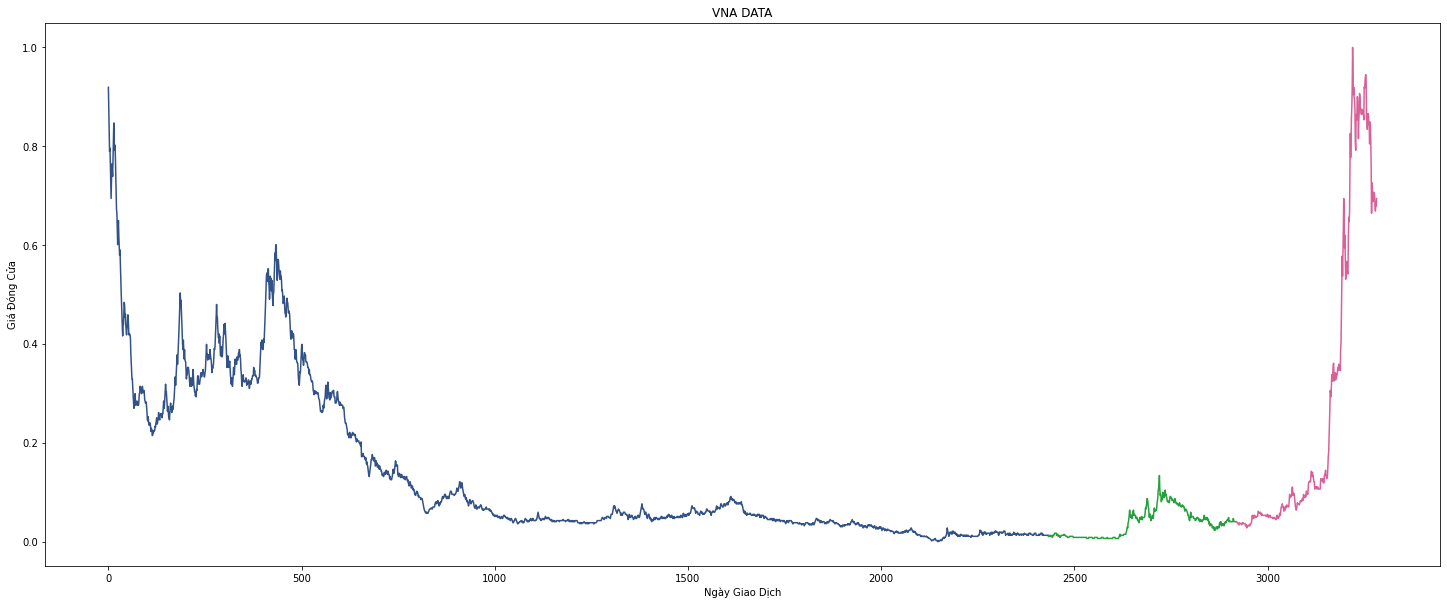

In [ ]:
plot_train_val_test(X_train, X_val, X_test, Y_train, Y_val, Y_test, 
                        range_Y_train, range_Y_val, range_Y_test)

# Check Point #3

Chia tập dữ liệu thành 3 phần để huấn luyện, đánh giá và kiểm thử

Nhóm chúng em sẽ lấy target trong 1 ngày để làm target cho ngày hôm trước.

Vì vậy:
* Các tập X sẽ bị xóa đi dữ liệu ngày cuối cùng
* Các tập Y sẽ bị xóa đi ngày đầu tiên

In [ ]:
input_train = X_train[X_train.columns[0:]].iloc[:-1]
input_val = X_val[X_val.columns[0:]].iloc[:-1]
input_test = X_test[X_test.columns[0:]].iloc[:-1]

Xóa cột `Ngày` và dữ liệu ngày cuối cùng

In [ ]:
input_train

,Giá bình quân,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,KL,GT
Ngày,,,,,,,
2008-09-09,0.649045,0.976293,1.000000,1.000000,0.966140,0.157138,2.213450e-01
2008-10-09,0.615924,0.658836,0.850932,0.837398,0.927765,0.129340,1.654959e-01
2008-11-09,0.585775,0.625216,0.809524,0.794715,0.882619,0.017838,2.173193e-02
2008-12-09,0.557113,0.594612,0.770186,0.756098,0.839729,0.001260,1.461341e-03
2008-09-15,0.561571,0.565517,0.770186,0.792683,0.839729,0.245998,2.909164e-01
...,...,...,...,...,...,...,...
2018-06-27,0.012739,0.012931,0.012422,0.012195,0.013544,0.001016,4.042351e-05
2018-06-28,0.012739,0.012931,0.012422,0.012195,0.013544,0.000005,2.176650e-07
2018-06-29,0.012739,0.012931,0.012422,0.012195,0.013544,0.002133,8.488937e-05


In [ ]:
target_train = Y_train[1:]
target_val = Y_val[1:]
target_test = Y_test[1:]

Xóa dữ liệu ngày đầu tiên của các tập Y

In [ ]:
target_train.shape

(2432,)

**Bước 5:** So sánh dự đoán của tập Val với thực tế

In [ ]:
def plot_prediction(actual, prediction, title='VNA Giao dịch và Dự đoán', y_label='Gía đóng cửa', x_label='Ngày giao dịch'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    # Plot actual and predicted close values
    plt.plot(actual, '#00FF00', label='Giao dịch thực tế')
    plt.plot(prediction, '#0000FF', label='Dự đoán')
    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()

In [ ]:
plot_prediction(target_val, predict_val)

# Check Point #4



## Mô hình LSTM - Long short term memory

**Bước 1 :** Import thư viện cần thiết và load dữ liệu

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

In [ ]:
input_train

,Giá bình quân,Giá tham chiếu,Giá mở cửa,Giá cao nhất,Giá thấp nhất,KL,GT
Ngày,,,,,,,
2008-09-09,0.649045,0.976293,1.000000,1.000000,0.966140,0.157138,2.213450e-01
2008-10-09,0.615924,0.658836,0.850932,0.837398,0.927765,0.129340,1.654959e-01
2008-11-09,0.585775,0.625216,0.809524,0.794715,0.882619,0.017838,2.173193e-02
2008-12-09,0.557113,0.594612,0.770186,0.756098,0.839729,0.001260,1.461341e-03
2008-09-15,0.561571,0.565517,0.770186,0.792683,0.839729,0.245998,2.909164e-01
...,...,...,...,...,...,...,...
2018-06-27,0.012739,0.012931,0.012422,0.012195,0.013544,0.001016,4.042351e-05
2018-06-28,0.012739,0.012931,0.012422,0.012195,0.013544,0.000005,2.176650e-07
2018-06-29,0.012739,0.012931,0.012422,0.012195,0.013544,0.002133,8.488937e-05


In [ ]:
target_train.shape

(2432,)

**Bước 3:** Chỉnh lại shape của input và output trước khi đưa vào mô hình LSTM

In [ ]:
# Convert to np.array
input_train_ar = np.array(input_train)
input_val_ar = np.array(input_val)
input_test_ar = np.array(input_test)

# Chọn time_step cho mô hình LSTM
time_steps = 1

In [ ]:
input_train_ar.shape

(2432, 7)

In [ ]:
# Thay đổi shape của tập X
input_train_lstm = input_train_ar.reshape(input_train_ar.shape[0], time_steps, input_train_ar.shape[1])
input_val_lstm = input_val_ar.reshape(input_val_ar.shape[0], time_steps, input_val_ar.shape[1])
input_test_lstm = input_test_ar.reshape(input_test_ar.shape[0], time_steps, input_test_ar.shape[1])

In [ ]:
input_train_lstm.shape

(2432, 1, 7)

In [ ]:
target_train.shape

(2432,)

**Bước 3:** Xây dựng mô hình LSTM đơn giản

In [ ]:
# #Building the LSTM Model
lstm = Sequential()
# unit = hidden state
lstm.add(LSTM(units=128, input_shape=(time_steps, input_train_ar.shape[1]), activation='relu', return_sequences=False))
# lop dau vao hinh tron
lstm.add(Dense(1))

In [ ]:
# Compile the model
# adam tim diem cuc tri 
lstm.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               69632     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


**Bước 4:** Huấn luyện mô hình

In [ ]:
# batch size 32 du lieu
BS=32
epoch=100

In [ ]:
history = lstm.fit(input_train_lstm,
                   target_train,
                   epochs=epoch,
                   batch_size=BS,
                   validation_data=(input_val_lstm, target_val),
                   verbose=1,
                   shuffle=False)

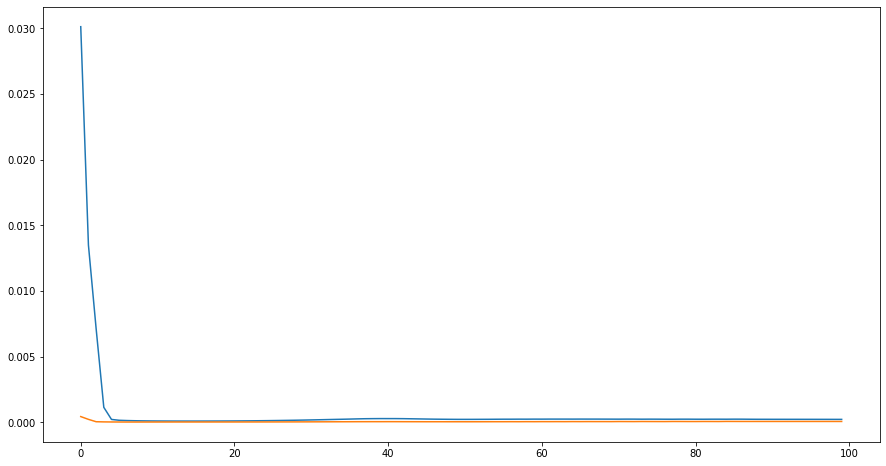

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

**Bước 5:** Đánh giá trên tập Val

In [ ]:
predict_val_lstm1 = lstm.predict(input_val_lstm)

In [ ]:
predict_val_lstm1.shape

(485, 1)

In [ ]:
target_val.shape

(485,)

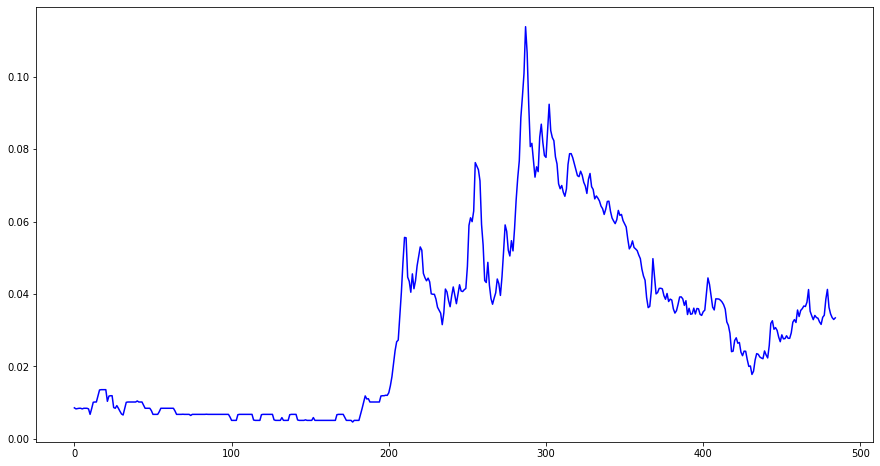

In [ ]:
plt.plot(predict_val_lstm1, '#0000FF', label='Dự đoán trên tập Val')

**Bước 6:** So sánh kết quả dự đoán của Val và thực tế

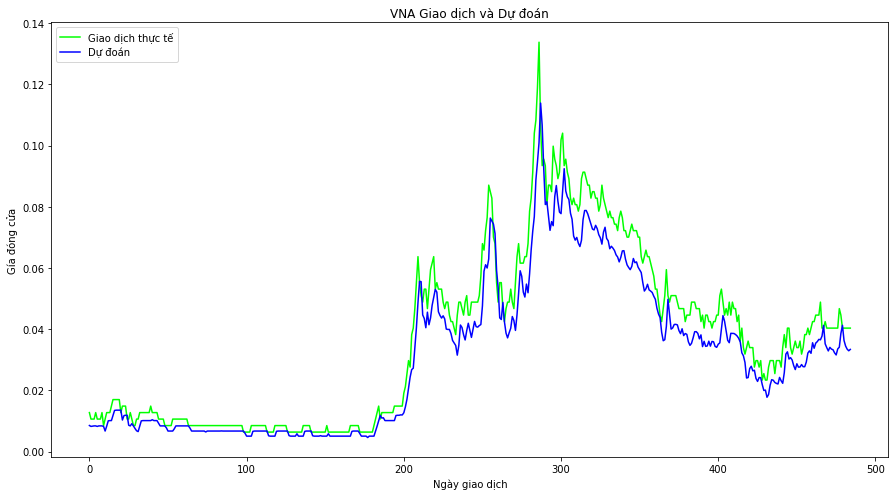

In [ ]:
plot_prediction(target_val, predict_val_lstm1)

**Bước 7:** Đánh giá mô hình LSTM cơ bản vừa training

In [ ]:
predict_train_lstm1 = lstm.predict(input_train_lstm)
train_Score_lstm1 = mean_squared_error(predict_train_lstm1.flatten(), target_train)
print('Train Score: %.4f MSE (%.4f RMSE)' % (train_Score_lstm1, math.sqrt(train_Score_lstm1)))

val_Score_lstm1 = mean_squared_error(predict_val_lstm1.flatten(), target_val)
print('Val Score: %.8f MSE (%.8f RMSE)' % (val_Score_lstm1, math.sqrt(val_Score_lstm1)))

predict_test_lstm1 = lstm.predict(input_test_lstm)
test_Score_lstm1 = mean_squared_error(predict_test_lstm1.flatten(), target_test)
print('Test Score: %.8f MSE (%.8f RMSE)' % (test_Score_lstm1, math.sqrt(test_Score_lstm1)))

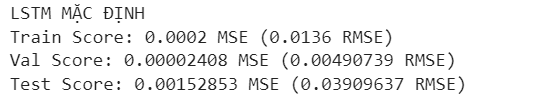

In [ ]:
print('%.8f'%test_Score_lstm1)

0.00122747


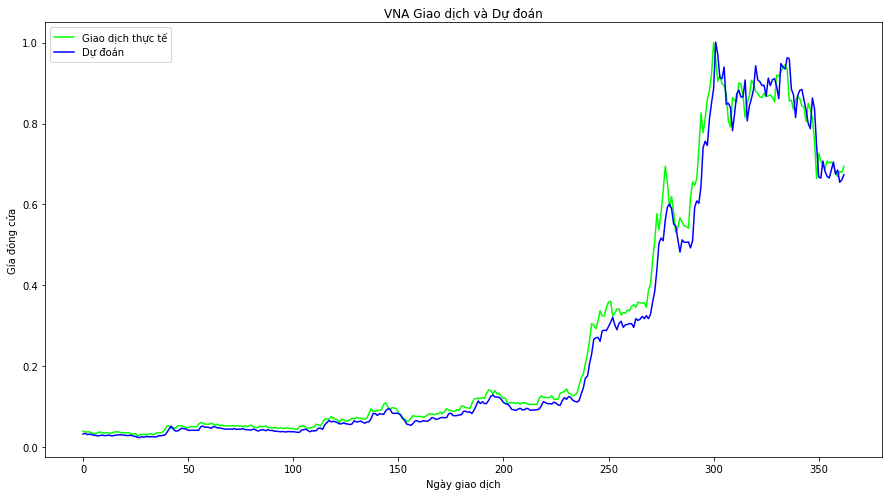

In [ ]:
plot_prediction(target_test, predict_test_lstm1)

# Check Point #5

Đã xây dựng, training và đánh giá bằng mô hình LSTM cơ bản

## Thử lần lượt các tham số

In [ ]:
time_steps=1

In [ ]:
def check_param(un=32, bs=64, drop_out=0.1, time_step=1):
    # build model
    lstm_test = Sequential()
    lstm_test.add(LSTM(units=un, dropout=drop_out, input_shape=(time_steps, input_train_ar.shape[1]), activation='relu', return_sequences=False))
    lstm_test.add(Dense(1))
    
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    lstm_test.compile(loss='mean_squared_error', optimizer=opt)
    
    lstm_test.fit(input_train_lstm,
                   target_train,
                   epochs=100,
                   batch_size=bs,
                   validation_data=(input_val_lstm, target_val),
                   verbose=1,
                   shuffle=False)
    
    predict_val = lstm_test.predict(input_val_lstm)
    score_val = mean_squared_error(predict_val.flatten(), target_val)
    return ('%8f'%score_val)

#### units

In [ ]:
units = [8, 16, 32, 64, 128]

In [ ]:
sc_val = []
for i in units:
    sc_v=check_param(un=i)
    sc_val.append(sc_v)

In [ ]:
sc_val

['0.000029', '0.000018', '0.000017', '0.000019', '0.000018']

In [ ]:
dt = {'Units': units, 'Score Val': sc_val}
df = pd.DataFrame(dt)
df

,Units,Score Val
0,8,0.000029
1,16,0.000018
2,32,0.000017
3,64,0.000019
4,128,0.000018


Chọn units = 32

#### batch_size

In [ ]:
batch_size = [8, 16, 32, 64, 128]

In [ ]:
sc_val_bs = []
for i in batch_size:
    sc_v_bs=check_param(bs=i)
    sc_val_bs.append(sc_v_bs)

In [ ]:
sc_val_bs

['0.000025', '0.000022', '0.000044', '0.000019', '0.000019']

In [ ]:
dt = {'Batch Size': batch_size, 'Score Val BS': sc_val_bs}
df = pd.DataFrame(dt)
df

,Batch Size,Score Val BS
0,8,0.000025
1,16,0.000022
2,32,0.000044
3,64,0.000019
4,128,0.000019


Chọn batch_size = 64

#### drop_out

In [ ]:
drop_out = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

In [ ]:
sc_val_dr = []
for i in drop_out:
    sc_v_dr=check_param(drop_out=i)
    sc_val_dr.append(sc_v_dr)

In [ ]:
sc_val_dr

In [ ]:
dt = {'Drop Out': drop_out, 'Score Val DR': sc_val_dr}
df = pd.DataFrame(dt)
df

,Drop Out,Score Val DR
0,0.05,0.000022
1,0.10,0.000048
2,0.15,0.000044
3,0.20,0.000045
4,0.25,0.000026
5,0.30,0.000188
6,0.35,0.000158
7,0.40,0.000388
8,0.45,0.000193
9,0.50,0.000573


Chọn drop_out=0.05

## Improved LSTM Model

**Bước 1:** Xây dựng improved LSTM model

In [ ]:
# Set up hyperparameters
batch_size = 64
epochs = 100

In [ ]:
lstm2 = Sequential()
lstm2.add(LSTM(units=32, dropout= 0.05, input_shape=(time_steps, input_train_ar.shape[1]), activation='relu', return_sequences=False))
lstm2.add(Dense(1))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm2.compile(loss='mean_squared_error', optimizer=opt)

In [ ]:
lstm2.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 32)                5120      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


**Bước 2:** Train improved LSTM model

In [ ]:
history2 = lstm2.fit(input_train_lstm,
                     target_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_data=(input_val_lstm, target_val),
                     verbose=1,
                     shuffle=False)

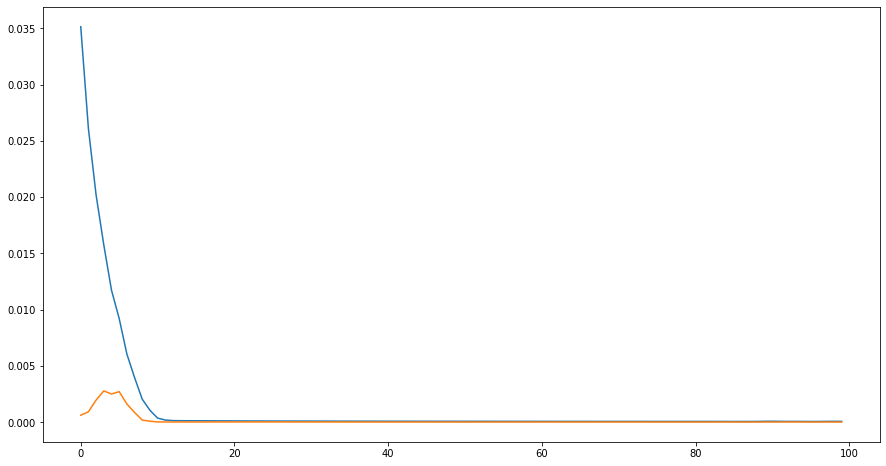

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.show()

**Step 3:** Make prediction on improved LSTM model

In [ ]:
predict_val_lstm2 = lstm2.predict(input_val_lstm)

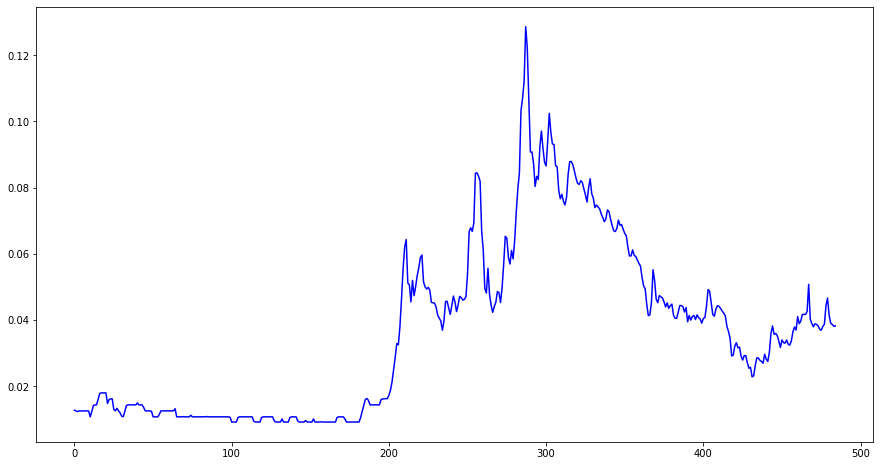

In [ ]:
plt.plot(predict_val_lstm2, '#0000FF', label='Dự đoán trên tập Val')

**Step 4:** plot the results

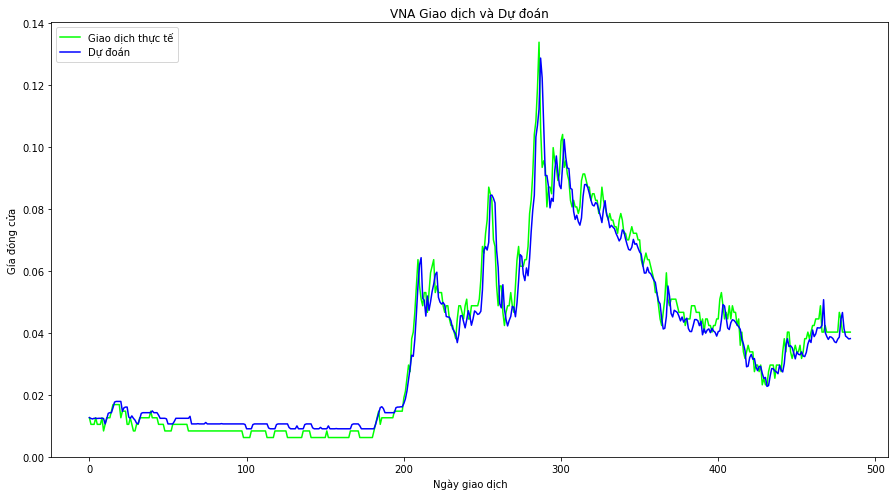

In [ ]:
plot_prediction(target_val, predict_val_lstm2)

**Step 5:** Get the test score

In [ ]:
print('LSTM CẢI TIẾN')
predict_train_lstm2 = lstm2.predict(input_train_lstm)
train_Score_lstm2 = mean_squared_error(predict_train_lstm2.flatten(), target_train)
print('Train Score: %.4f MSE (%.4f RMSE)' % (train_Score_lstm2, math.sqrt(train_Score_lstm2)))

val_Score_lstm2 = mean_squared_error(predict_val_lstm2.flatten(), target_val)
print('Val Score: %.8f MSE (%.8f RMSE)' % (val_Score_lstm2, math.sqrt(val_Score_lstm2)))

predict_test_lstm2 = lstm2.predict(input_test_lstm)
test_Score_lstm2 = mean_squared_error(predict_test_lstm2.flatten(), target_test)
print('Test Score: %.8f MSE (%.8f RMSE)' % (test_Score_lstm2, math.sqrt(test_Score_lstm2)))

LSTM CẢI TIẾN
* Train Score: 0.0007 MSE (0.0260 RMSE)
* Val Score: 0.00005266 MSE (0.00725667 RMSE)
* Test Score: 0.00118950 MSE (0.03448910 RMSE)

## SO SÁNH VỚI LSTM MẶC ĐỊNH

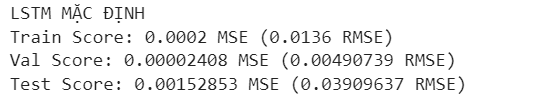

In [ ]:
def plot_final(actual, prediction_improved, prediction, title='VNA Giao dịch và Dự đoán', y_label='Gía đóng cửa', x_label='Ngày giao dịch'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    # Plot actual and predicted close values
    plt.plot(actual, '#00FF00', label='Giao dịch thực tế')
    plt.plot(prediction, '#0000FF', label='Dự đoán mặc định')
    plt.plot(prediction_improved, '#FF0000', label='Dự đoán cải tiến')
    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()

LSTM


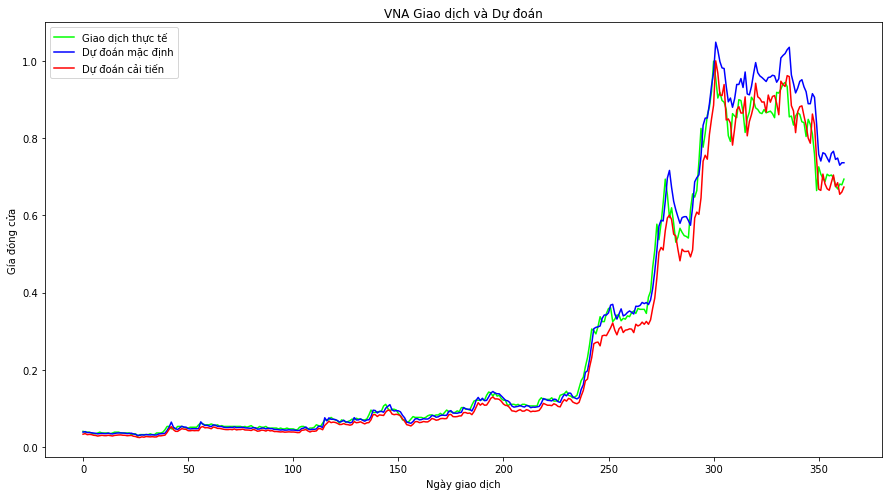

In [ ]:
print('LSTM')
plot_final(target_test, predict_test_lstm1, predict_test_lstm2)